(In order to load the stylesheet of this notebook, execute the last code cell in this notebook)

# Yelp Reviews and Clustering

In this assignment, we will be working with the [Yelp dataset](http://cs-people.bu.edu/kzhao/teaching/yelp_dataset_challenge_academic_dataset.tar). You can find the format of the dataset [here](https://www.yelp.com/dataset_challenge).

First, we will look at Review Objects and perform some [sentiment analysis](http://sentiment.christopherpotts.net/) on the review text.

You will need to preprocess the text using a stemming algorithm. The Porter stemming algorithm is a well-known one. Then, use a lexicon to assign a score to a review based on the positive/negative words you find in the text. You can find various lexicons [here](http://sentiment.christopherpotts.net/lexicons.html).

After you have assigned scores to the reviews based on the text analysis, compare your scores with the stars associated with the reviews. **(20 pts)**

In [15]:
import nltk
import math
import json
import nltk.sentiment.util as nsu
import nltk.sentiment.vader as nsv
from pprint import pprint

def halfRound(x):
    if(x > 4):
        return 5
    elif(x >= 3 and x < 3.5):
        return 3
    elif(x > 3.5 and x <= 4):
        return 4
    elif(x > 2 and x < 3):
        return 2
    elif(x < 2):
        return 1
    return x
    
def sentenceScore(sentence):
    analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='vader_lexicon.txt')
    s = analyzer.polarity_scores(sentence)
    neg = float(s['neg'])
    pos = float(s['pos'])
    score = 0
    if neg > pos:
        score = 5 - ((neg - pos) + 1) * 3
    elif neg == pos:
        return 3
    else:
        score = ((pos - neg) + 1) * 3
    return halfRound(score);

my_dict = {}
count = 0
match = 0
file_name="yelp_academic_dataset_review.json"
with open(file_name) as f:
    for line in f:
        count = count + 1
        js = json.loads(line)
        buff1 = int(sentenceScore(js["text"]))
        buff2 = int(js["stars"])
        if buff1 == buff2:
            match = match + 1
        if(count == 1000):
            break
print float(match)/float(count)
        


0.378


Just some testing code below of nltk package of python

In [ ]:
import nltk
import math
import json
import nltk.sentiment.util as nsu
import nltk.sentiment.vader as nsv
 
def halfRound(x):
    if x % 1 >= 0.5:
        return round(x) 
    else:
        return round(x - 0.5)
    
def sentenceScore(sentence):
    analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='vader_lexicon.txt')
    s = analyzer.polarity_scores(sentence)
    neg = float(s['neg'])
    pos = float(s['pos'])
    score = 0
    if neg > pos:
        score = 5 - ((neg - pos) + 1) * 3
    elif neg == pos:
        return 3
    else:
        score = ((pos - neg) + 1) * 3
    return halfRound(score)

sentence = "i have only had this camera for one full day and i have to say that it is wonderful"
print sentenceScore(sentence)

    



Visualization and short (detailed) analysis. **(10 pts)**

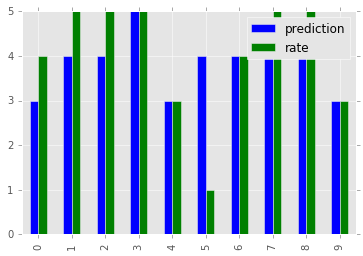

In [37]:
import pandas as pd
import nltk
import math
import json
import nltk.sentiment.util as nsu
import nltk.sentiment.vader as nsv
from pprint import pprint
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

def halfRound(x):
    if(x > 4):
        return 5
    elif(x >= 3 and x < 3.5):
        return 3
    elif(x > 3.5 and x <= 4):
        return 4
    elif(x > 2 and x < 3):
        return 2
    elif(x < 2):
        return 1
    return x
    
def sentenceScore(sentence):
    analyzer = nltk.sentiment.vader.SentimentIntensityAnalyzer(lexicon_file='vader_lexicon.txt')
    s = analyzer.polarity_scores(sentence)
    neg = float(s['neg'])
    pos = float(s['pos'])
    score = 0
    if neg > pos:
        score = 5 - ((neg - pos) + 1) * 3
    elif neg == pos:
        return 3
    else:
        score = ((pos - neg) + 1) * 3
    return halfRound(score);
myList=[]
originList=[]
countList = []
count = 0
match = 0
file_name="yelp_academic_dataset_review.json"
with open(file_name) as f:
    for line in f:
        countList.append(count)
        js = json.loads(line)
        buff1 = int(sentenceScore(js["text"]))
        myList.append(buff1)
        buff2 = int(js["stars"])
        originList.append(buff2)
        count = count + 1
        if(count == 10):
            break
my_df = pd.DataFrame(myList)
origin_df = pd.DataFrame(originList)
plt.figure(figsize=(3,4))
result = pd.concat([my_df, origin_df], axis=1)
result.columns=['prediction', 'rate']
result.plot(kind='bar')


Analysis: The algorithm I am using is to compute the polarity of positive and negative words and convert the ratio between them to score in the range of 1 to 5. In most of the conditions, the difference between prediction and real rating is no larger than 2. So if it's a good restaurant, it could be rated as 4 or 5 stars but the algorithm I am using is not sensitive enough to detect such difference. I think if we use some machine learning model and train the model with some sample data with reviews and ratings. It will be more sensitive to give a precise prediction.

Now, let's look at Business Objects. Try to find culinary districts in Las Vegas. These are characterized by closeness and similarity of restaurants. Use the "longitude" and "latitude" to cluster closeness. Use "categories" and "attributes" to cluster for similarity.

Find clusters using the 3 different techniques we discussed in class: k-means++, hierarchical, and GMM. Explain your data representation and how you determined certain parameters (for example, the number of clusters in k-means++). **(30 pts)**

Things you may want to consider:
1. The spatial coordinates and restaurant categories/attributes have different units of scale. Your results could be arbitrarily skewed if you don't incorporate some scaling.
2. Some restaurant types are inherently more common than others. For example, there are probably lots of "pizza" restaurants. You may want to normalize your vectors so that you don't end up with only clusters of "pizza" restaurants.

In [29]:
from random import random
from bisect import bisect
import numpy as np

def weighted_choice(choices):
    values, weights = zip(*choices)
    total = 0
    cum_weights = []
    for w in weights:
        total += w
        cum_weights.append(total)
    x = random() * total
    i = bisect(cum_weights, x)
    return values[i]

def kplusplus(k, restaurant):
    """initialize"""
    x = np.random.randint(4659, size=1)
    center = restaurant.items()[x]

weighted_choice([("WHITE",90), ("RED",8), ("GREEN",2)])

print x

[3880]


In [32]:
'''
{
    'type': 'business',
    'business_id': (encrypted business id),
    'name': (business name),
    'neighborhoods': [(hood names)],
    'full_address': (localized address),
    'city': (city),
    'state': (state),
    'latitude': latitude,
    'longitude': longitude,
    'stars': (star rating, rounded to half-stars),
    'review_count': review count,
    'categories': [(localized category names)]
    'open': True / False (corresponds to closed, not business hours),
    'hours': {
        (day_of_week): {
            'open': (HH:MM),
            'close': (HH:MM)
        },
        ...
    },
    'attributes': {
        (attribute_name): (attribute_value),
        ...
    },
}
'''
restaurant = {}
import json
file_name="yelp_academic_dataset_business.json"
count = 0
with open(file_name) as f:
    for line in f:
        js = json.loads(line)
        city = js['city']
        b_type = str(js['categories'])
        if(city == "Las Vegas" and "Restaurant" in b_type):
            count = count + 1
            bId =  js['business_id']
            geo = [float(js['latitude']), float(js['longitude'])]
            tmp = [geo, float(js['stars']), b_type]
            restaurant[bId] = tmp
            
print len(restaurant)            
print restaurant.items()[0]


4658
(u'tfcgb7IA_xjiuJonxpA4-A', [[36.1065014765822, -115.172454491258], 4.5, "[u'Burgers', u'American (Traditional)', u'Asian Fusion', u'Restaurants']"])


[2705]


Visualize your clusters using each technique. Label your clusters. **(10 pts)**

Now let's detect outliers. These are the ones who are the farthest from the centroids of their clusters. Track them down and describe any interesting observations that you can make. **(10 pts)**

Give a short (detailed) analysis comparing the 3 techniques. **(10 pts)**

-----------------

In [ ]:
# Code for setting the style of the notebook
from IPython.core.display import HTML
def css_styling():
    styles = open("../theme/custom.css", "r").read()
    return HTML(styles)
css_styling()